# Финальный проект. Вариант 2

### Задание 1. A/B-тестирование

In [43]:
# импортируем нужные библиотеки

import pandas as pd
from scipy import stats
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.stats.proportion import proportions_ztest
from scipy.stats import shapiro, levene

In [5]:
# читаем наши данные

groups = pd.read_csv('Проект_2_groups.csv', sep=';')
groups_add = pd.read_csv('Проект_2_group_add.csv')
active_studs = pd.read_csv('Проект_2_active_studs.csv')
checks = pd.read_csv('Проект_2_checks.csv', sep=';')

### Предобработка данных:

In [6]:
groups = groups.rename(columns={groups.columns[0]: 'student_id', groups.columns[1]: 'group'})
groups.head()

,student_id,group
0,1489,B
1,1627,A
2,1768,B
3,1783,B
4,1794,A


In [7]:
# заметим, что группы очень несбалансированы. Это надо будет учитывать при интерпретации

groups.groupby('group').agg({'student_id': 'count'})

,student_id
group,
A,14671
B,59813


In [8]:
groups_add = groups_add.rename(columns={groups_add.columns[0]: 'student_id', groups_add.columns[1]: 'group'})
groups_add.head()

,student_id,group
0,5694584,B
1,5694830,B
2,5695057,B
3,5698872,B
4,5699067,B


In [9]:
groups_add.groupby('group').agg({'student_id': 'count'})

,student_id
group,
A,22
B,70


In [10]:
active_studs.head()

,student_id
0,581585
1,5723133
2,3276743
3,4238589
4,4475369


In [11]:
checks = checks.rename(columns={checks.columns[1]: 'revenue'})
checks.head()

,student_id,revenue
0,1627,990.0
1,3185,690.0
2,25973,690.0
3,26280,690.0
4,100300,990.0


### Агрегация по пользователям

In [12]:
checks_agg = checks.groupby('student_id').agg(revenue=('revenue','sum'), orders=('revenue','count')).reset_index()
active_studs_agg = active_studs.groupby('student_id').agg(active_days=('student_id','count')).reset_index()

In [13]:
df = groups.merge(checks_agg, on='student_id', how='left') \
.merge(groups_add, on='student_id', how='left').merge(active_studs_agg, on='student_id', how='left')

In [14]:
# собираем датафрейм со всеми показателями

df = df.fillna({'orders':0, 'revenue':0.0, 'active_days':0})
df = df.drop('group_y', axis=1)
df = df.rename(columns={'group_x': 'group'})
df.head()

,student_id,group,revenue,orders,active_days
0,1489,B,0.0,0.0,0.0
1,1627,A,990.0,1.0,1.0
2,1768,B,0.0,0.0,0.0
3,1783,B,0.0,0.0,0.0
4,1794,A,0.0,0.0,0.0


In [29]:
# количество пользователей с оплатой, но без активности

users_payment_no_activity = df[(df['revenue'] > 0) & (df['active_days'] == 0)]
users_payment_no_activity.shape[0]

149

### Анализируем метрики по группам

Какие метрики я смотрел и почему:

1. Conversion (конверсия в покупку). Ключ к пониманию, влияет ли новая механика на долю пользователей, которые покупают.
2. ARPU (average revenue per user). Учитывает объём покупателей и их платежи. Показывает влияния на доход на пользователя.
3. AOV (average order value). Показывает, если изменения влияют на средний чек покупателей.

In [16]:
metrics = df.groupby('group').agg(
    users_count=('student_id','count'),
    buyers=('orders', 'sum'),
    orders=('orders','sum'),
    revenue=('revenue','sum')
).reset_index() 

In [17]:
metrics['conversion'] = metrics['buyers'] / metrics['users_count']
metrics['arpu'] = metrics['revenue'] / metrics['users_count']
metrics['aov'] = metrics['revenue'] / metrics['buyers']

In [18]:
metrics

,group,users_count,buyers,orders,revenue,conversion,arpu,aov
0,A,14671,107.0,107.0,92096.0000,0.007293,6.277418,860.710280
1,B,59813,433.0,433.0,479330.0036,0.007239,8.013810,1106.997699


In [19]:
# делим пользователей на контрольную и тестовую группу для расчета метрик

groupA = df[df['group']=='A']
groupB = df[df['group']=='B']

In [20]:
# конверсия

conv_a = (groupA['orders']>0).sum()
conv_b = (groupB['orders']>0).sum()
n_a = groupA.shape[0]
n_b = groupB.shape[0]

### Проверим распределения на нормальность и равенство дисперсий

In [41]:
# метрики для проверки

arpu_A = groupA['revenue']
arpu_B = groupB['revenue']

aov_A = groupA[groupA['revenue'] > 0]['revenue']
aov_B = groupB[groupB['revenue'] > 0]['revenue']

In [44]:
# проверка нормальности с помощью теста Шапиро-Уилка

stat_arpu_A, p_arpu_A = shapiro(arpu_A)
stat_arpu_B, p_arpu_B = shapiro(arpu_B)
stat_aov_A, p_aov_A = shapiro(aov_A)
stat_aov_B, p_aov_B = shapiro(aov_B)

/opt/tljh/user/lib/python3.7/site-packages/scipy/stats/morestats.py:1760: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


In [46]:
print("Значения p-value наших тестов:")
print(f"ARPU A: {p_arpu_A:.5f}, ARPU B: {p_arpu_B:.5f}")
print(f"AOV A : {p_aov_A:.5f}, AOV B : {p_aov_B:.5f}")

Значения p-value наших тестов:
ARPU A: 0.00000, ARPU B: 0.00000
AOV A : 0.00000, AOV B : 0.00000


P-value сильно меньше 0,05. Распределения явно ненормальные.

In [51]:
# проверяем однородность дисперсий с помощью теста Левена

stat_lev_ARPU, p_lev_ARPU = levene(arpu_A, arpu_B)
stat_lev_AOV, p_lev_AOV = levene(aov_A, aov_B)

In [53]:
print(f"ARPU: {p_lev_ARPU:.5f}")
print(f"AOV: {p_lev_AOV:.5f}")

ARPU: 0.08883
AOV: 0.04338


У показателя ARPU p-value > 0.05 --> мы не можем назвать дисперсии разными.
У показателя AOV p-value < 0.05 --> можно сделать вывод, что дисперсии различны.

### Проводим статистистические тесты.

Почему я выбрал именно эти тесты:

1) Conversion. Тип данных бинарный (покупка есть или покупки нет). Мат. ожидание напрямую связано с успехами.
   Используем z-тест для сравения долей. 
   Гипотезы:
   H0: CR1 = CR2
   H1: CR1 ≠ CR2
   
2) ARPU. Много пользователей с нулевым revenue. Нормальность нарушена.
   Используем bootstrap по средним значениям.
   Гипотезы:
   H0: mean(ARPU_A) = mean(ARPU_B)
   H1: mean(ARPU_A) ≠ mean(ARPU_B)
   
3) AOV. Аналогично ARPU - нет нормальности.
   Используем bootstrap по средним значениям.
   Гипотезы:
   H0: mean(AOV_A) = mean(AOV_B)
   H1: mean(AOV_A) ≠ mean(AOV_B)

In [21]:
# проводим z-test для проверки гипотезы о статистической разницы в конверсии

z_stat, pval = proportions_ztest([conv_b, conv_a], [n_b, n_a])

In [38]:
# для метрики ARPU я решил воспользоваться методом bootstrap

def bootstrap_diff_mean(x, y, n_boot=5000, seed=42):
    rng = np.random.RandomState(seed)
    diffs = []
    for _ in range(n_boot):
        xs = rng.choice(x, len(x), replace=True)
        ys = rng.choice(y, len(y), replace=True)
        diffs.append(ys.mean() - xs.mean())
    return np.percentile(diffs, [2.5,97.5]), np.mean(diffs)

ci_arpu, diff_mean_arpu = bootstrap_diff_mean(arpu_A, arpu_B)

In [36]:
# AOV среди покупателей

aov_A = groupA[groupA['revenue'] > 0]['revenue'].values
aov_B = groupB[groupB['revenue'] > 0]['revenue'].values

ci_aov, diff_mean_aov = bootstrap_diff_mean(aov_A, aov_B)

In [40]:
# выоводим значения метрик

print(f"Conversion A: {conv_a/n_a:.4f}, B: {conv_b/n_b:.4f}, p-value={pval:.4f}")
print(f"ARPU diff (B-A): mean={diff_mean_arpu:.2f}, 95% CI={ci_arpu}")
print(f"AOV diff (B-A): mean={diff_mean_aov:.2f}, 95% CI={ci_aov}")

Conversion A: 0.0073, B: 0.0072, p-value=0.9448
ARPU diff (B-A): mean=1.74, 95% CI=[-0.18253296  3.55200041]
AOV diff (B-A): mean=247.83, 95% CI=[ 72.40309105 411.53285172]


/opt/tljh/user/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


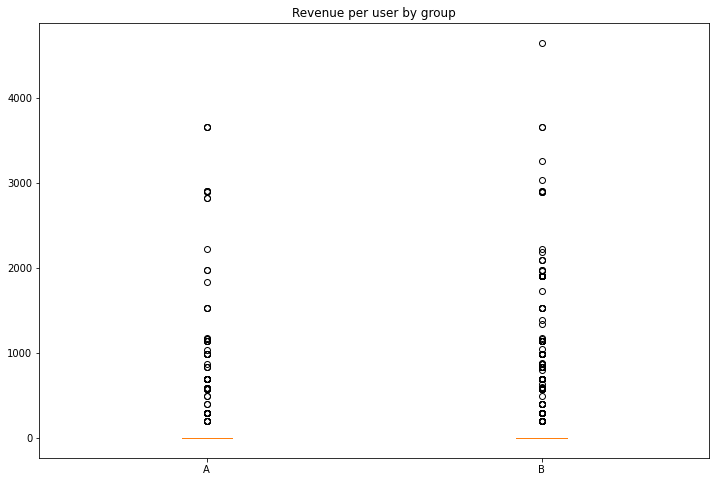

In [25]:
# визуализируем распределения

plt.figure(figsize=(12,8))
plt.boxplot([groupA['revenue'], groupB['revenue']], labels=['A','B'])
plt.title('Revenue per user by group')
plt.show()

/opt/tljh/user/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3208: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asarray(a).size
/opt/tljh/user/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


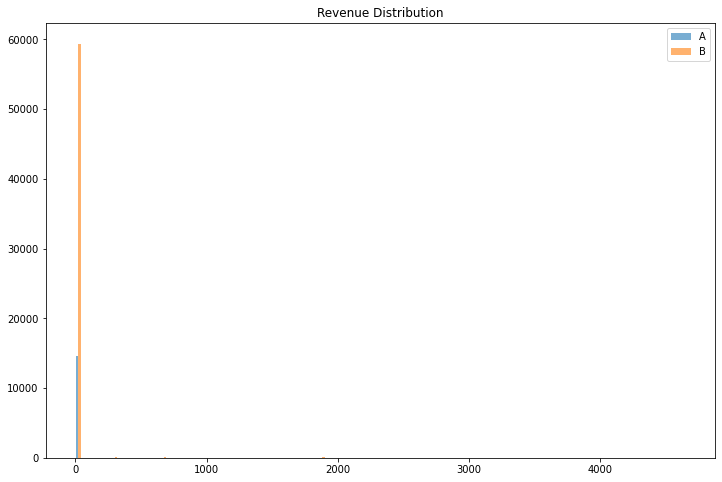

In [26]:
plt.figure(figsize=(12,8))
plt.hist([groupA['revenue'], groupB['revenue']], bins=100, label=['A','B'], alpha=0.6)
plt.legend()
plt.title('Revenue Distribution')
plt.show()

## Выводы по результатам анализа:

1. Конверсия практически не изменилась. Различия оказались статистически незначимыми. P-value равен примерно 0,94. Можно сделать вывод, что новая механика не привела к увеличению доли покупателей.

2. ARPU вырос, но совершенно незначительно. 95% доверительный интервал включает 0. Общий доход на пользователя отличается мало и не проходит стандартный тест на значимость.

3. AOV среди покупателей растет статистически значимо. Мы уверены на 95%, что фича увеличивает средний чек. Увеличение AOV
напрямую повышает доход компании. 

4. Новая механика не увеличивает конверсию, но повышает средний чек у тех, кто уже покупает. Возможно, новая механика оплаты делает оплату более удобной или стимулирует лояльных клиентов тратить больше.

#### Рекомендации:

Я считаю, что запускать новую механику оплаты услуг на сайте на всех пользователей пока что не стоит. Следует провести дополнительное сегментное тестирование.

Например, рассмотреть запуск новой механики по сегментам, где рост AOV даёт наибольший профит. 

Можно провести дополнительные типы анализа: когортный анализ, распределение по дням, сравнение retention. 

#### Что нужно делать в первую очередь:

1. Провести целевой роллаут для определенных сегментов (либо провести еще один A/B тест, но с выровненными выборками в группах).

2. Разобраться с выбросами и источниками роста AOV.

3. При подтверждении эффекта в целевых сегментах - масштабировать.